In [2]:
!python --version

Python 3.10.0


In [3]:
try:
    import tensorflow as tf
    print("TensorFlow is installed, version:", tf.__version__)
except ImportError:
    print("TensorFlow is NOT installed.")
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow is installed, version: 2.13.0
GPU Available: []


In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

(32, 256, 256, 3)
---------------------------------------------
[0 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 2 0 0 2 0 0 1 0]
---------------------------------------------
tf.Tensor(
[[[184. 179. 183.]
  [189. 184. 188.]
  [193. 188. 192.]
  ...
  [179. 174. 180.]
  [183. 178. 184.]
  [187. 182. 188.]]

 [[182. 177. 181.]
  [189. 184. 188.]
  [193. 188. 192.]
  ...
  [177. 172. 178.]
  [180. 175. 181.]
  [183. 178. 184.]]

 [[186. 181. 185.]
  [192. 187. 191.]
  [196. 191. 195.]
  ...
  [182. 177. 183.]
  [183. 178. 184.]
  [184. 179. 185.]]

 ...

 [[133. 127. 131.]
  [144. 138. 142.]
  [161. 155. 159.]
  ...
  [138. 135. 144.]
  [141. 138. 147.]
  [161. 158. 167.]]

 [[153. 147. 151.]
  [159. 153. 157.]
  [163. 157. 161.]
  ...
  [167. 161. 171.]
  [156. 150. 160.]
  [134. 128. 138.]]

 [[148. 142. 146.]
  [156. 150. 154.]
  [158. 152. 156.]
  ...
  [150. 144. 154.]
  [153. 147. 157.]
  [152. 146. 156.]]], shape=(256, 256, 3), dtype=float32)
--------------------------------------

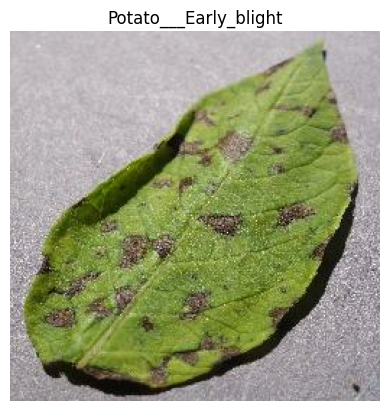

In [9]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print("---------------------------------------------")
    print(label_batch.numpy())
    print("---------------------------------------------")
    print(image_batch[0])
    print("---------------------------------------------")
    print(image_batch[0].numpy())
    print("---------------------------------------------")
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_name[label_batch[0]])
    plt.axis("off")

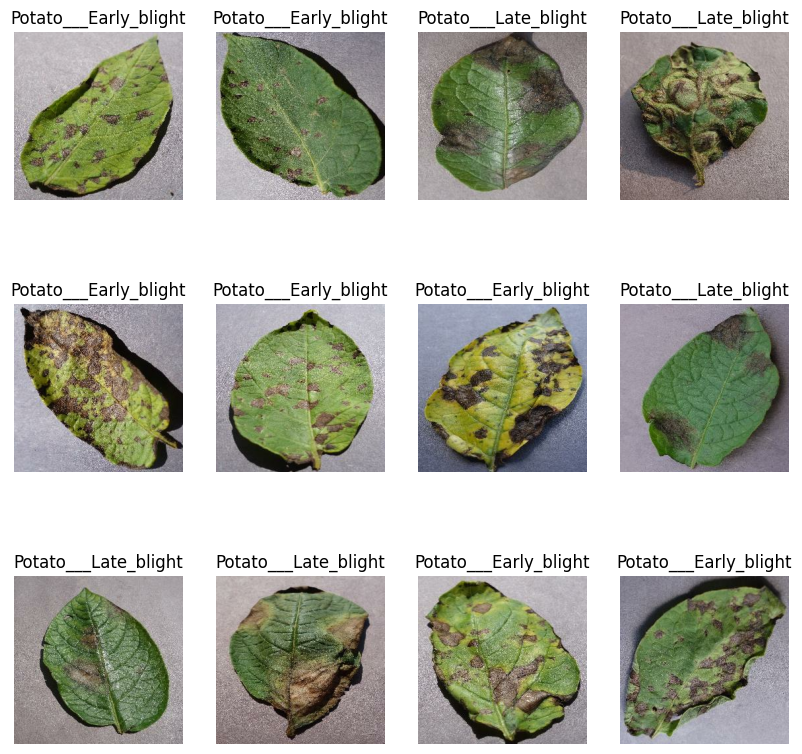

In [10]:
plt.figure(figsize = (10,10))
for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[label_batch[i]])
    plt.axis("off")

In [11]:
# 80% ==> training
# 20 ==> 10% validation, 10% test

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [15]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [19]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [25]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [26]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape = input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [29]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 104s 2s/step - loss: 0.9125 - accuracy: 0.5006 - val_loss: 0.9505 - val_accuracy: 0.6719
Epoch 2/50
54/54 [==============================] - 87s 2s/step - loss: 0.7827 - accuracy: 0.6470 - val_loss: 0.6735 - val_accuracy: 0.7500
Epoch 3/50
54/54 [==============================] - 79s 1s/step - loss: 0.5756 - accuracy: 0.7697 - val_loss: 0.5011 - val_accuracy: 0.7917
Epoch 4/50
54/54 [==============================] - 82s 2s/step - loss: 0.4842 - accuracy: 0.8096 - val_loss: 0.4067 - val_accuracy: 0.8229
Epoch 5/50
54/54 [==============================] - 77s 1s/step - loss: 0.4709 - accuracy: 0.8183 - val_loss: 0.3885 - val_accuracy: 0.8229
Epoch 6/50
54/54 [==============================] - 44s 815ms/step - loss: 0.4132 - accuracy: 0.8241 - val_loss: 0.2899 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 44s 810ms/step - loss: 0.2863 - accuracy: 0.8918 - val_loss: 0.2545 - val_accuracy: 0.8854
Epoch 8/50
54

In [30]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 332ms/step - loss: 0.0235 - accuracy: 0.9922


In [31]:
scores

[0.023502860218286514, 0.9921875]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

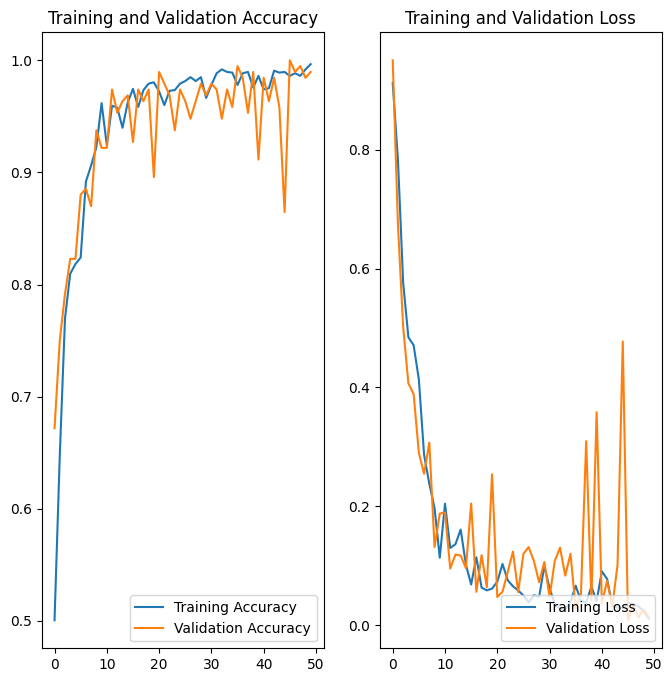

In [35]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
Actual label: Potato___Late_blight
1/1 [==============================] - 1s 546ms/step
Predicted label: Potato___Late_blight


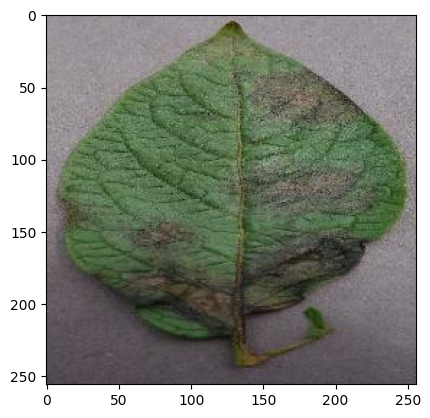

In [36]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):

     first_image = images_batch[0].numpy().astype('uint8')
     first_label = labels_batch[0].numpy()
     
     print("first image to predict")
     plt.imshow(first_image)
     print("Actual label:",class_name[first_label])

     batch_prediction = model.predict(images_batch)
     print("Predicted label:",class_name[np.argmax(batch_prediction[0])])

In [37]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


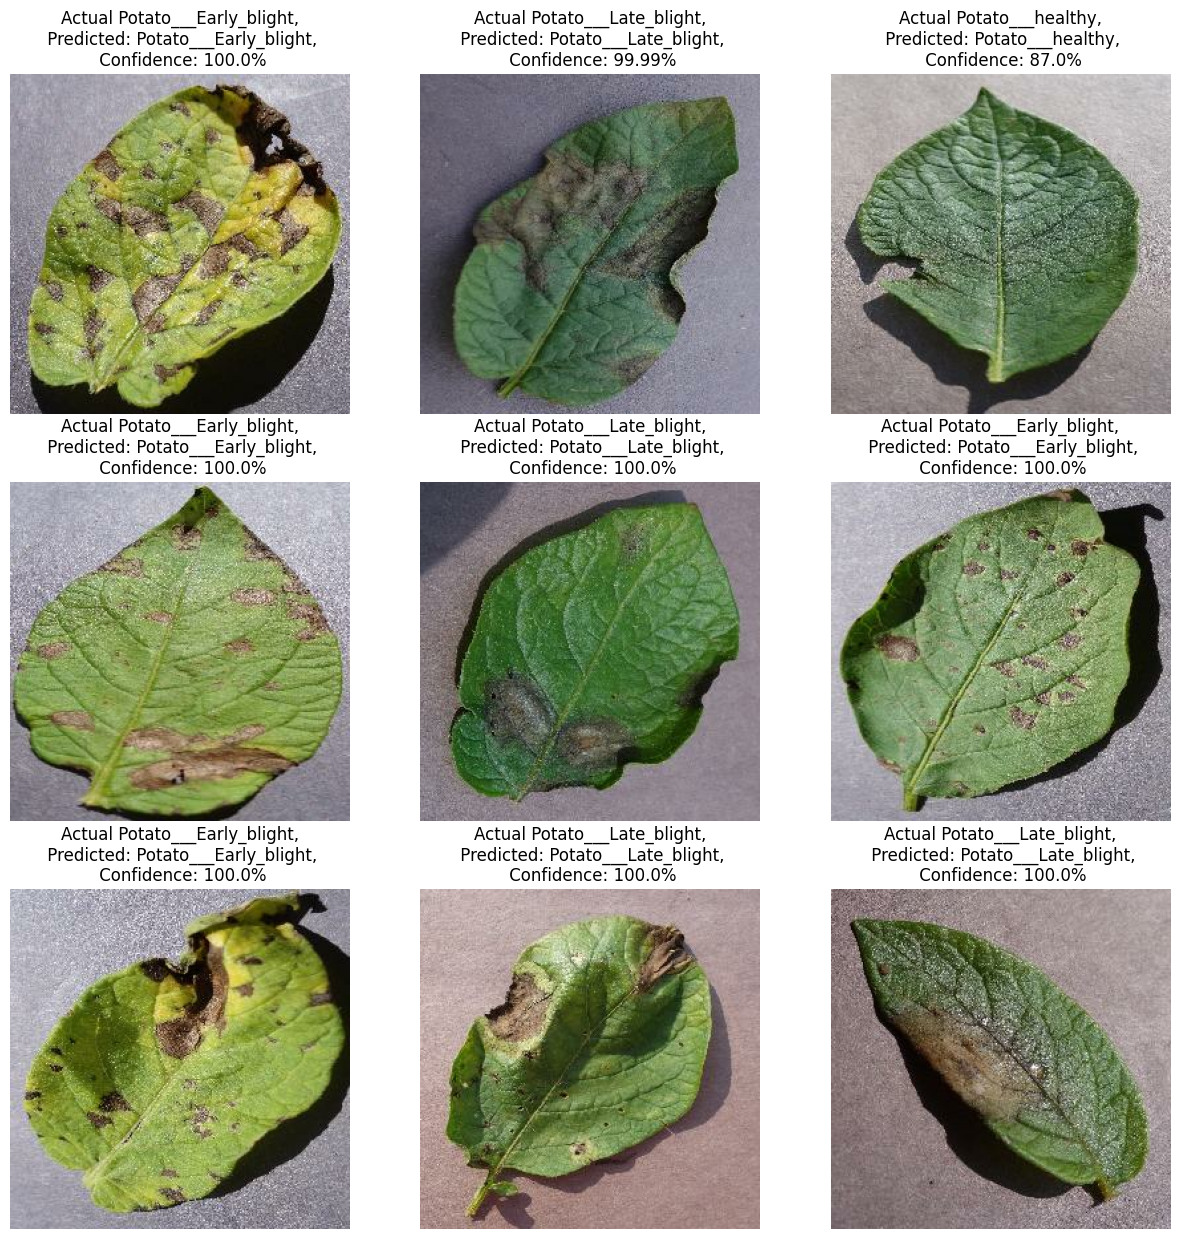

In [38]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f"Actual {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")

In [39]:
model_version = 1
model.export(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


Saved artifact at '../models/1'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 256, 256, 3)
  Returns:
    float32 Tensor, shape=(None, 3)


In [40]:
import os

folder_path = "../models/2"

if os.path.exists(folder_path):
    print(os.listdir(folder_path))
else:
    print(f"Folder not found: {folder_path}")

['assets']


In [41]:
mv = 2
model.save(f"../models/{mv}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
